<a href="https://colab.research.google.com/github/tomek1911/bee-or-wasp-deep-learning/blob/master/bee_vs_wasp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

from google.colab import files

# import your kaggle credentials in kaggle.json file sa explained in:
# https://www.kaggle.com/general/74235
# files.upload()

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# check if kaggle API works
! kaggle datasets list

ref                                                    title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
gpreda/covid-world-vaccination-progress                COVID-19 World Vaccination Progress                  39KB  2021-01-30 11:46:26           4219  
ayushggarg/all-trumps-twitter-insults-20152021         All Trump's Twitter insults (2015-2021)             581KB  2021-01-20 16:51:05            822  
sevgisarac/temperature-change                          Temperature change                                  778KB  2020-12-24 20:06:36            893  
jorgesandoval/wind-power-generation                    Wind Power Generation Data                          245KB  2021-01-07 18:45:08            366  
cdminix/us-drought-meteorological-data                 US Drought & Meteorological Data       

In [3]:
! kaggle datasets download jerzydziewierz/bee-vs-wasp --unzip

 99% 554M/559M [00:04<00:00, 127MB/s]
100% 559M/559M [00:04<00:00, 129MB/s]


In [4]:
import os
import numpy as np
import pandas as pd
import glob
import torch
import cv2
import random
import imutils
import imgaug as ia
import imgaug.augmenters as iaa
import imgaug.parameters as iap
from math import *
from PIL import Image
from imgaug.augmenters import Sequential
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
import torchvision.transforms.functional as tf

## Wczytanie danych

In [5]:
data = pd.read_csv("/content/kaggle_bee_vs_wasp/labels.csv")
for i in data.index:
    data["path"].iloc[i] = data["path"].iloc[i].replace("\\", "/")
le = LabelEncoder()
le.fit(data["label"])
data["label"] = le.transform(data["label"])
data.info()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11421 entries, 0 to 11420
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   11421 non-null  int64 
 1   path                 11421 non-null  object
 2   is_bee               11421 non-null  int64 
 3   is_wasp              11421 non-null  int64 
 4   is_otherinsect       11421 non-null  int64 
 5   is_other             11421 non-null  int64 
 6   photo_quality        11421 non-null  int64 
 7   is_validation        11421 non-null  int64 
 8   is_final_validation  11421 non-null  int64 
 9   label                11421 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 892.4+ KB


## Podział danych 

In [6]:
def split_data(dataset):
    index = list()
    validation = pd.DataFrame()
    final_validation = pd.DataFrame()
    for i in data.index:
        if dataset["is_validation"].iloc[i] == 1:
            validation = validation.append(dataset.iloc[i])
            index.append(i)
        if dataset["is_final_validation"].iloc[i] == 1:    
            final_validation = final_validation.append(dataset.iloc[i])
            index.append(i)

    dataset = dataset.drop(dataset.index[index])
    dataset = dataset.reset_index()
    validation = validation.reset_index()
    final_validation = final_validation.reset_index()
    return dataset, validation, final_validation 

train_df, val_df, test_df = split_data(data)

# sanity check
print("Length of train dataset: ", len(train_df))
print("Length of validation dataset: " ,len(val_df))
print("Length of test dataset: ", len(test_df))

val_df.label = val_df.label.astype(np.int64)
test_df.label = test_df.label.astype(np.int64)

Length of train dataset:  7939
Length of validation dataset:  1719
Length of test dataset:  1763


## Augmentacja

In [7]:
class Transforms():
    def __init__(self, train: bool = False):
      self.train = train
    
    def rotate(self, image, angle):
      angle = random.uniform(-angle, +angle)

      transformation_matrix = torch.tensor([
          [+cos(radians(angle)), -sin(radians(angle))], 
          [+sin(radians(angle)), +cos(radians(angle))]
      ])

      image = imutils.rotate(np.array(image), angle)

      return Image.fromarray(image)

    def resize(self, image, img_size):
      image = tf.resize(image, img_size)
      return image

    def color_jitter(self, image):
      color_jitter = transforms.ColorJitter(brightness=0.3, 
                                            contrast=0.3,
                                            saturation=0.3, 
                                            hue=0.1)
      image = color_jitter(image)
      return image

    def crop(self, image, crops):
      left = int(random.uniform(0, crops['left']))
      top = int(random.uniform(0, crops['top']))
      width = int(random.uniform(crops['width'], 224))
      height = int(random.uniform(crops['height'], 224))

      image = tf.crop(image, top, left, height, width)

      img_shape = np.array(image).shape
      return image

    def __call__(self, image):
      image = Image.fromarray(image)

      image = self.resize(image, (224, 224))
      if self.train:
        image = self.crop(image, {'left': 15,
                                  'top': 15,
                                  'width': 210,
                                  'height': 210
                                  })
        image = self.resize(image, (224, 224))
        image = self.color_jitter(image)
        image = self.rotate(image, angle=10)

      image = tf.to_tensor(image)
      image = tf.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      return image

## Dataset

In [8]:
class BeeWaspDataset(Dataset):
  def __init__(self, image_dir: str = None, dataframe: pd.DataFrame = None, train: bool = False,
               transforms: Transforms = None):
    self.image_dir = image_dir
    self.dataframe = dataframe
    self.train = train
    self.transforms = transforms

  def __getitem__(self, index):
    image_path = os.path.join(self.image_dir, self.dataframe.iloc[index]["path"])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if self.transforms:
      image = self.transforms(image)
    
    if self.train:
      label = self.dataframe.iloc[index]["label"]
      return image, label
    else: 
      return image

  def __len__(self):
      return len(self.dataframe)

## Przygotowanie datasetów do treningu

In [9]:
train_data = BeeWaspDataset(dataframe=train_df,
                            image_dir="/content/kaggle_bee_vs_wasp/",
                            train=True,
                            transforms=Transforms(train=True))

val_data = BeeWaspDataset(dataframe=val_df,
                          image_dir="/content/kaggle_bee_vs_wasp/",
                          train=True,
                          transforms=Transforms(train=True))

test_data = BeeWaspDataset(dataframe=test_df,
                          image_dir="/content/kaggle_bee_vs_wasp/",
                          train=True,
                          transforms=Transforms(train=False))

train_loader = DataLoader(dataset=train_data, shuffle=True, batch_size=32, num_workers=4)
val_loader = DataLoader(dataset=val_data, shuffle=True, batch_size=32, num_workers=4)
test_loader = DataLoader(dataset=test_data, shuffle=True, batch_size=32, num_workers=4)

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

## Model sieci Resnet

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=4):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*16*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


# model = ResNet50()
# summary(batch_size=32, input_size=(3, 224, 224), model=model)

## Wytrenowany model z bilbiotek pytorch

In [11]:
from torchsummary import summary
from torchvision import transforms, models


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = models.resnet50(pretrained=False)
        self.model.fc = nn.Linear(512*4, 4)
    
    def forward(self, x):
        output = self.model(x)
        return output

# model = Net()
# summary(batch_size=32, input_size=(3, 224, 224), model=model)

## Skrypt trenujący

In [12]:
import time
import copy
import gc 

from google.colab import drive
import pickle

# drive.mount('/content/gdrive')

gc.collect()

def train(model, optimizer, scheduler, num_epochs, criterion, device):
  since = time.time()

  train_loss_history = []
  val_loss_history = []

  train_acc_history = []
  val_acc_history = []

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10) 

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      total_batches = len(dataloaders[phase])
      for batch_idx, batch in enumerate(dataloaders[phase]):
        # print('Batch {}/{}'.format(batch_idx, total_batches))

        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                optimizer.step()
            
        # statistics
        running_loss += loss.detach().item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'train':
        train_acc_history.append(epoch_acc.item())
        train_loss_history.append(epoch_loss)
      else:
        val_acc_history.append(epoch_acc.item())
        val_loss_history.append(epoch_loss)

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "/content/kaggle_bee_vs_wasp/checkpoint.pth")

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)

  # with open('/content/gdrive/My Drive/results_bee_wasp/lists.txt', 'w') as f:
  #   f.write("\n".join(train_acc_history))
  #   f.write("\n")
  #   f.write("\n".join(val_acc_history))
  #   f.write("\n")
  #   f.write("\n".join(train_loss_history))
  #   f.write("\n")
  #   f.write("\n".join(val_loss_history))

  # with open('/content/gdrive/My Drive/results_bee_wasp/train_acc_history.txt', 'wb') as fp:
  #   pickle.dump(train_acc_history, fp)

  # with open('/content/gdrive/My Drive/results_bee_wasp/val_acc_history.txt', 'wb') as fp:
  #   pickle.dump(val_acc_history, fp)

  # with open('/content/gdrive/My Drive/results_bee_wasp/train_loss_history.txt', 'wb') as fp:
  #   pickle.dump(train_loss_history, fp)

  # with open('/content/gdrive/My Drive/results_bee_wasp/val_loss_history.txt', 'wb') as fp:
  #   pickle.dump(val_loss_history, fp)

  print(train_acc_history)
  print(val_acc_history)
  print(train_loss_history)
  print(val_loss_history)

  return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history

In [13]:
test_net = Net()
print(test_net)
test_net.model.layer4 = nn.Identity()
print('-\n'*5)
print (test_net)

class MyIdentity(nn.Identity):
    def __init__(self):
      super(MyIdentity, self).__init__()

    def forward(self, x):
      # print(x.shape)
      return x


class SimplifiedResNet(Net):
  def __init__(self):
    super(SimplifiedResNet, self).__init__()

    self.model.layer4 = MyIdentity()
    self.model.fc = nn.Linear(1024, 4)


test_net2 = SimplifiedResNet() 
print(test_net2)

Net(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): C

In [14]:
from torch.optim import lr_scheduler


use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
net = Net()
net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

model, train_acc_history, val_acc_history, train_loss_history, val_loss_history = train(net, optimizer, exp_lr_scheduler, 40, criterion, device)

True
Epoch 0/39
----------
train Loss: 1.2837 Acc: 0.4489
val Loss: 1.1830 Acc: 0.5224

Epoch 1/39
----------
train Loss: 1.1772 Acc: 0.5348
val Loss: 1.2312 Acc: 0.5300

Epoch 2/39
----------
train Loss: 1.0811 Acc: 0.5798
val Loss: 1.0102 Acc: 0.5893

Epoch 3/39
----------
train Loss: 1.0281 Acc: 0.5960
val Loss: 1.1245 Acc: 0.5439

Epoch 4/39
----------
train Loss: 1.0211 Acc: 0.5949
val Loss: 0.9187 Acc: 0.6353

Epoch 5/39
----------
train Loss: 0.9699 Acc: 0.6075
val Loss: 0.9040 Acc: 0.6382

Epoch 6/39
----------
train Loss: 0.9612 Acc: 0.6138
val Loss: 1.0752 Acc: 0.5718

Epoch 7/39
----------
train Loss: 0.8923 Acc: 0.6357
val Loss: 0.8666 Acc: 0.6550

Epoch 8/39
----------
train Loss: 0.8739 Acc: 0.6413
val Loss: 0.8594 Acc: 0.6638

Epoch 9/39
----------
train Loss: 0.8712 Acc: 0.6484
val Loss: 0.8460 Acc: 0.6614

Epoch 10/39
----------
train Loss: 0.8680 Acc: 0.6452
val Loss: 0.8467 Acc: 0.6562

Epoch 11/39
----------
train Loss: 0.8706 Acc: 0.6449
val Loss: 0.8470 Acc: 0.658

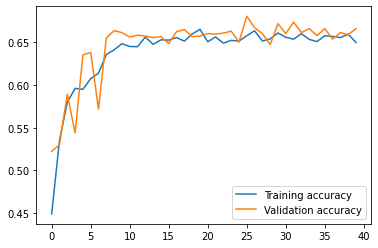

In [15]:
import matplotlib.pyplot as plt

plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show()

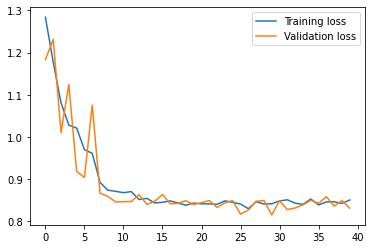

In [16]:
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.legend(['Training loss', 'Validation loss'])
plt.show()

In [17]:
torch.save(model.state_dict(), 'checkpoint.pth')

# Podsumowanie modelu

In [19]:
from sklearn.metrics import confusion_matrix

model_ft = Net()
model_ft.load_state_dict(torch.load("/content/kaggle_bee_vs_wasp/checkpoint.pth"))
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
model_ft.cuda()
model_ft.eval()

nb_classes = 4

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

True
[[313  52   5 114]
 [ 25 199   1 132]
 [ 15   3  17  93]
 [ 53  77  15 605]]
[64.66942149 55.74229692 13.28125    80.66666667]


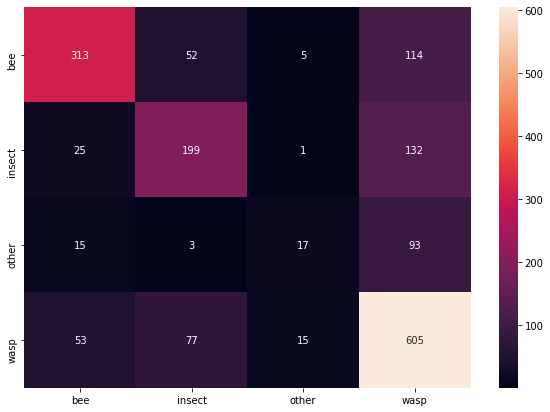

In [20]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(conf_mat, index = [i for i in ['bee', 'insect', 'other', 'wasp']],
                     columns = [i for i in ['bee', 'insect', 'other', 'wasp']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt="d")

